# Analyse Dermatologique avec OpenCV

##   Introduction

Ce notebook implémente le **module d'analyse visuelle OpenCV** pour un système d'aide au diagnostic dermatologique.

### Rôle dans le système global

Le système complet combine :
1. **Module OpenCV**  : Extraction de caractéristiques visuelles objectives
2. **Vision-Language Model (VLM)** : Analyse sémantique
3. **Module RAG** : Recherche de connaissances médicales

###  Limites importantes

Ce module :
-  Extrait des caractéristiques visuelles mesurables
-  Calcule des scores objectifs (asymétrie, couleur, texture)
-  NE produit AUCUN diagnostic médical
-  NE donne AUCUNE recommandation médicale

### Pipeline d'analyse

1. Prétraitement de l'image
2. Segmentation de la lésion
3. Extraction de caractéristiques (forme, couleur, texture)
4. Calcul de scores visuels

##  Installation et Import des Bibliothèques

In [ ]:
# Installation des dépendances 
#!pip install opencv-python numpy scikit-image matplotlib

  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/39.0 MB ? eta -:--:--
    --------------------------------------- 0.5/39.0 MB 1.4 MB/s eta 0:00:28
    --------------------------------------- 0.8/39.0 MB 1.3 MB/s eta 0:00:29
   - -------------------------------------- 1.3/39.0 MB 1.3 MB/s eta 0:00:29
   - -------------------------------------- 1.6/39.0 MB 1.4 MB/s eta 0:00:27
   - -------------------------------------- 1.8/39.0 MB 1.4 MB/s eta 0:00:28
   -- ------------------------------------- 2.1/39.0 MB 1.5 MB/s eta 0:00:26
   -- ------------------------------------- 2.6/39.0 MB 1.5 MB/s eta 0:00:25
   --- ------------------------------------ 3.1/39.0 MB 1.6 MB/s eta 0:00:24
   --- ------------------------------------ 3.4/39.0 MB 1.6 MB/s eta 0:00:23
   ---- ------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import measure
import json
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Configuration d' affichage
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print(" Bibliothèques importées avec succès")
print(f"Version OpenCV: {cv2.__version__}")

 Bibliothèques importées avec succès
Version OpenCV: 4.12.0


## 1️ Prétraitement de l'Image

In [6]:
def preprocess_image(image: np.ndarray, target_size: Tuple[int, int] = (512, 512)) -> Dict[str, np.ndarray]:
    """
    Prétraite l'image dermatologique.
    
    Args:
        image: Image RGB d'entrée
        target_size: Taille cible (largeur, hauteur)
    
    Returns:
        Dictionnaire contenant les images prétraitées
    """
    # Redimensionnement
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    
    # Réduction du bruit avec Gaussian Blur
    denoised = cv2.GaussianBlur(resized, (5, 5), 0)
    
    # Conversion d'espaces couleur
    hsv = cv2.cvtColor(denoised, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(denoised, cv2.COLOR_RGB2LAB)
    
    return {
        'original': image,
        'resized': resized,
        'denoised': denoised,
        'hsv': hsv,
        'lab': lab
    }

def visualize_preprocessing(preprocessed: Dict[str, np.ndarray]):
    """
    Visualise les étapes de prétraitement.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(preprocessed['original'])
    axes[0, 0].set_title('Image Originale')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(preprocessed['resized'])
    axes[0, 1].set_title('Image Redimensionnée (512×512)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(preprocessed['denoised'])
    axes[0, 2].set_title('Image Débruitée (Gaussian)')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(preprocessed['hsv'])
    axes[1, 0].set_title('Espace HSV')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(preprocessed['lab'])
    axes[1, 1].set_title('Espace LAB')
    axes[1, 1].axis('off')
    
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

print(" Fonctions de prétraitement définies")

 Fonctions de prétraitement définies


## 2️ Segmentation de la Lésion

In [7]:
def segment_lesion(preprocessed: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    Segmente la lésion cutanée en utilisant K-means et post-traitement.
    
    Args:
        preprocessed: Dictionnaire d'images prétraitées
    
    Returns:
        Dictionnaire contenant le masque et les contours
    """
    image = preprocessed['denoised']
    lab = preprocessed['lab']
    
    # K-means clustering sur l'espace LAB
    pixels = lab.reshape((-1, 3)).astype(np.float32)
    
    # K-means avec K=3 (peau saine, lésion, fond)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 3
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # Reshape des labels
    segmented = labels.reshape(image.shape[:2])
    
    # Identifier le cluster de la lésion (généralement le plus sombre en L*)
    l_values = [centers[i][0] for i in range(k)]
    lesion_cluster = np.argmin(l_values) if np.std(l_values) > 10 else np.argmax([np.sum(segmented == i) for i in range(k) if i != np.argmax(l_values)])
    
    # Créer le masque binaire
    mask = (segmented == lesion_cluster).astype(np.uint8) * 255
    
    # Post-traitement morphologique
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Remplir les trous
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # Garder le plus grand contour
        largest_contour = max(contours, key=cv2.contourArea)
        mask_filled = np.zeros_like(mask)
        cv2.drawContours(mask_filled, [largest_contour], -1, 255, -1)
        mask = mask_filled
    
    # Détecter les contours finaux
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return {
        'mask': mask,
        'contours': contours,
        'segmented_colored': segmented
    }

def visualize_segmentation(preprocessed: Dict[str, np.ndarray], segmentation: Dict[str, np.ndarray]):
    """
    Visualise les résultats de segmentation.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    image = preprocessed['denoised']
    mask = segmentation['mask']
    
    # Image originale
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Image Prétraitée')
    axes[0, 0].axis('off')
    
    # Masque binaire
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Masque de Segmentation')
    axes[0, 1].axis('off')
    
    # Contours sur l'image
    image_contours = image.copy()
    cv2.drawContours(image_contours, segmentation['contours'], -1, (0, 255, 0), 3)
    axes[1, 0].imshow(image_contours)
    axes[1, 0].set_title('Contours Détectés')
    axes[1, 0].axis('off')
    
    # Lésion isolée
    lesion_only = cv2.bitwise_and(image, image, mask=mask)
    axes[1, 1].imshow(lesion_only)
    axes[1, 1].set_title('Lésion Isolée')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print(" Fonctions de segmentation définies")

 Fonctions de segmentation définies


## 3️ Extraction de Caractéristiques

###  Caractéristiques de Forme

In [8]:
def extract_shape_features(mask: np.ndarray, contours: list) -> Dict:
    """
    Extrait les caractéristiques de forme de la lésion.
    
    Args:
        mask: Masque binaire de la lésion
        contours: Liste des contours détectés
    
    Returns:
        Dictionnaire de caractéristiques de forme
    """
    if len(contours) == 0:
        return {
            'area': 0,
            'perimeter': 0,
            'circularity': 0,
            'asymmetry_score': 0,
            'border_irregularity_score': 0
        }
    
    contour = max(contours, key=cv2.contourArea)
    
    # Aire et périmètre
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Circularité (1 = cercle parfait, <1 = irrégulier)
    circularity = 0
    if perimeter > 0:
        circularity = (4 * np.pi * area) / (perimeter ** 2)
        circularity = min(circularity, 1.0)
    
    # Score d'asymétrie (comparaison des moitiés)
    asymmetry_score = calculate_asymmetry(mask, contour)
    
    # Irrégularité des bords (variance de la distance au centre)
    border_irregularity = calculate_border_irregularity(contour)
    
    return {
        'area': float(area),
        'perimeter': float(perimeter),
        'circularity': float(circularity),
        'asymmetry_score': float(asymmetry_score),
        'border_irregularity_score': float(border_irregularity)
    }

def calculate_asymmetry(mask: np.ndarray, contour: np.ndarray) -> float:
    """
    Calcule le score d'asymétrie en comparant les moitiés de la lésion.
    """
    # Moments pour trouver le centre
    M = cv2.moments(contour)
    if M['m00'] == 0:
        return 0.0
    
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    
    h, w = mask.shape
    
    # Comparer moitiés horizontales
    left_half = mask[:, :cx] if cx < w else mask
    right_half = mask[:, cx:] if cx < w else mask
    right_half_flipped = cv2.flip(right_half, 1)
    
    # Redimensionner pour comparer
    min_width = min(left_half.shape[1], right_half_flipped.shape[1])
    if min_width > 0:
        left_resized = cv2.resize(left_half, (min_width, h))
        right_resized = cv2.resize(right_half_flipped, (min_width, h))
        
        # Différence entre les deux moitiés
        diff_h = np.sum(np.abs(left_resized.astype(float) - right_resized.astype(float)))
        total_h = np.sum(left_resized) + np.sum(right_resized)
        asymmetry_h = diff_h / (total_h + 1e-6)
    else:
        asymmetry_h = 0
    
    # Comparer moitiés verticales
    top_half = mask[:cy, :] if cy < h else mask
    bottom_half = mask[cy:, :] if cy < h else mask
    bottom_half_flipped = cv2.flip(bottom_half, 0)
    
    min_height = min(top_half.shape[0], bottom_half_flipped.shape[0])
    if min_height > 0:
        top_resized = cv2.resize(top_half, (w, min_height))
        bottom_resized = cv2.resize(bottom_half_flipped, (w, min_height))
        
        diff_v = np.sum(np.abs(top_resized.astype(float) - bottom_resized.astype(float)))
        total_v = np.sum(top_resized) + np.sum(bottom_resized)
        asymmetry_v = diff_v / (total_v + 1e-6)
    else:
        asymmetry_v = 0
    
    # Score final (moyenne des deux axes)
    return (asymmetry_h + asymmetry_v) / 2

def calculate_border_irregularity(contour: np.ndarray) -> float:
    """
    Calcule l'irrégularité des bords basée sur la variance des distances.
    """
    # Moments pour trouver le centre
    M = cv2.moments(contour)
    if M['m00'] == 0:
        return 0.0
    
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    
    # Calculer les distances de chaque point du contour au centre
    distances = []
    for point in contour:
        px, py = point[0]
        dist = np.sqrt((px - cx)**2 + (py - cy)**2)
        distances.append(dist)
    
    # Coefficient de variation (std/mean)
    if len(distances) > 0 and np.mean(distances) > 0:
        irregularity = np.std(distances) / np.mean(distances)
        return min(irregularity, 1.0)
    
    return 0.0

print(" Fonctions de caractéristiques de forme définies")

 Fonctions de caractéristiques de forme définies


###  Caractéristiques de Couleur

In [9]:
def extract_color_features(image: np.ndarray, hsv: np.ndarray, lab: np.ndarray, mask: np.ndarray) -> Dict:
    """
    Extrait les caractéristiques de couleur de la lésion.
    
    Args:
        image: Image RGB prétraitée
        hsv: Image en espace HSV
        lab: Image en espace LAB
        mask: Masque de la lésion
    
    Returns:
        Dictionnaire de caractéristiques de couleur
    """
    # Extraire les pixels de la lésion
    lesion_pixels_hsv = hsv[mask > 0]
    lesion_pixels_lab = lab[mask > 0]
    
    if len(lesion_pixels_hsv) == 0:
        return {
            'mean_hue': 0,
            'mean_saturation': 0,
            'mean_value': 0,
            'color_variance': 0,
            'redness_level': 'low',
            'darkness_score': 0
        }
    
    # Moyennes HSV
    mean_hue = np.mean(lesion_pixels_hsv[:, 0])
    mean_saturation = np.mean(lesion_pixels_hsv[:, 1])
    mean_value = np.mean(lesion_pixels_hsv[:, 2])
    
    # Variance de couleur (écart-type des canaux LAB)
    color_variance = np.mean([
        np.std(lesion_pixels_lab[:, 0]),
        np.std(lesion_pixels_lab[:, 1]),
        np.std(lesion_pixels_lab[:, 2])
    ])
    
    # Niveau de rougeur (basé sur Hue et canal a* de LAB)
    # Hue entre 0-20 ou 160-180 = rouge dans HSV
    red_hue_pixels = np.sum((lesion_pixels_hsv[:, 0] < 20) | (lesion_pixels_hsv[:, 0] > 160))
    red_ratio = red_hue_pixels / len(lesion_pixels_hsv)
    
    mean_a = np.mean(lesion_pixels_lab[:, 1])  # Canal a* (vert-rouge)
    
    # Déterminer le niveau de rougeur
    if red_ratio > 0.3 or mean_a > 140:
        redness_level = 'high'
    elif red_ratio > 0.15 or mean_a > 130:
        redness_level = 'medium'
    else:
        redness_level = 'low'
    
    # Score d'obscurité (basé sur canal L* de LAB)
    mean_lightness = np.mean(lesion_pixels_lab[:, 0])
    darkness_score = 1.0 - (mean_lightness / 255.0)  # Normalisé entre 0 et 1
    
    return {
        'mean_hue': float(mean_hue),
        'mean_saturation': float(mean_saturation),
        'mean_value': float(mean_value),
        'color_variance': float(color_variance),
        'redness_level': redness_level,
        'darkness_score': float(darkness_score)
    }

def visualize_color_features(image: np.ndarray, hsv: np.ndarray, mask: np.ndarray):
    """
    Visualise les caractéristiques de couleur.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Image originale
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Image Prétraitée')
    axes[0, 0].axis('off')
    
    # Canaux HSV
    axes[0, 1].imshow(hsv[:, :, 0], cmap='hsv')
    axes[0, 1].set_title('Canal Hue (Teinte)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(hsv[:, :, 1], cmap='gray')
    axes[0, 2].set_title('Canal Saturation')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(hsv[:, :, 2], cmap='gray')
    axes[1, 0].set_title('Canal Value (Luminosité)')
    axes[1, 0].axis('off')
    
    # Lésion avec masque
    lesion_only = cv2.bitwise_and(image, image, mask=mask)
    axes[1, 1].imshow(lesion_only)
    axes[1, 1].set_title('Lésion Isolée')
    axes[1, 1].axis('off')
    
    # Histogramme de teinte
    lesion_pixels_hsv = hsv[mask > 0]
    if len(lesion_pixels_hsv) > 0:
        axes[1, 2].hist(lesion_pixels_hsv[:, 0], bins=50, color='blue', alpha=0.7)
        axes[1, 2].set_title('Distribution des Teintes')
        axes[1, 2].set_xlabel('Hue')
        axes[1, 2].set_ylabel('Fréquence')
    else:
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

print(" Fonctions de caractéristiques de couleur définies")

 Fonctions de caractéristiques de couleur définies


###  Caractéristiques de Texture

In [10]:
def extract_texture_features(image: np.ndarray, mask: np.ndarray) -> Dict:
    """
    Extrait les caractéristiques de texture en utilisant GLCM.
    
    Args:
        image: Image RGB prétraitée
        mask: Masque de la lésion
    
    Returns:
        Dictionnaire de caractéristiques de texture
    """
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Appliquer le masque
    lesion_gray = cv2.bitwise_and(gray, gray, mask=mask)
    
    # Extraire la région de la lésion
    coords = cv2.findNonZero(mask)
    if coords is None or len(coords) == 0:
        return {
            'homogeneity': 0,
            'contrast': 0,
            'energy': 0,
            'correlation': 0,
            'texture_homogeneity_level': 'low'
        }
    
    x, y, w, h = cv2.boundingRect(coords)
    lesion_crop = lesion_gray[y:y+h, x:x+w]
    
    # Réduire les niveaux de gris pour GLCM (plus rapide)
    lesion_crop = (lesion_crop / 16).astype(np.uint8)
    
    # Calculer la matrice GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    try:
        glcm = graycomatrix(lesion_crop, distances=distances, angles=angles, 
                           levels=16, symmetric=True, normed=True)
        
        # Extraire les propriétés
        homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
        contrast = np.mean(graycoprops(glcm, 'contrast'))
        energy = np.mean(graycoprops(glcm, 'energy'))
        correlation = np.mean(graycoprops(glcm, 'correlation'))
        
        # Déterminer le niveau d'homogénéité de texture
        if homogeneity > 0.7:
            texture_level = 'high'
        elif homogeneity > 0.5:
            texture_level = 'medium'
        else:
            texture_level = 'low'
        
        return {
            'homogeneity': float(homogeneity),
            'contrast': float(contrast),
            'energy': float(energy),
            'correlation': float(correlation),
            'texture_homogeneity_level': texture_level
        }
    
    except Exception as e:
        print(f"Erreur dans le calcul de texture: {e}")
        return {
            'homogeneity': 0,
            'contrast': 0,
            'energy': 0,
            'correlation': 0,
            'texture_homogeneity_level': 'low'
        }

print(" Fonctions de caractéristiques de texture définies")

 Fonctions de caractéristiques de texture définies


## 4️ Scoring Clinique Visuel

In [11]:
def calculate_visual_risk_level(shape_features: Dict, color_features: Dict, texture_features: Dict) -> Dict:
    """
    Calcule un niveau de risque visuel basé sur des critères objectifs.
    
     Ce score est purement visuel et ne constitue pas un diagnostic médical.
    
    Args:
        shape_features: Caractéristiques de forme
        color_features: Caractéristiques de couleur
        texture_features: Caractéristiques de texture
    
    Returns:
        Dictionnaire avec scores normalisés et niveau de risque visuel
    """
    # Score d'asymétrie (déjà normalisé 0-1)
    asymmetry_score = shape_features['asymmetry_score']
    
    # Score de bord (irrégularité, déjà normalisé 0-1)
    border_score = shape_features['border_irregularity_score']
    
    # Score de couleur (combinaison variance + obscurité)
    color_score = min((color_features['color_variance'] / 50.0 + color_features['darkness_score']) / 2, 1.0)
    
    # Score de texture (1 - homogénéité, car moins homogène = plus de risque)
    texture_score = 1.0 - texture_features['homogeneity']
    
    # Score global (moyenne pondérée)
    weights = {'asymmetry': 0.3, 'border': 0.3, 'color': 0.25, 'texture': 0.15}
    global_score = (
        weights['asymmetry'] * asymmetry_score +
        weights['border'] * border_score +
        weights['color'] * color_score +
        weights['texture'] * texture_score
    )
    
    # Déterminer le niveau de risque visuel
    if global_score < 0.3:
        risk_level = 'low'
    elif global_score < 0.6:
        risk_level = 'medium'
    else:
        risk_level = 'high'
    
    return {
        'asymmetry_score': float(asymmetry_score),
        'border_irregularity_score': float(border_score),
        'color_score': float(color_score),
        'texture_score': float(texture_score),
        'global_visual_score': float(global_score),
        'visual_risk_level': risk_level
    }

print(" Fonction de scoring visuel définie")

 Fonction de scoring visuel définie


##  Fonction Principale d'Analyse

In [12]:
def analyze_skin_image(image_path: str, visualize: bool = True) -> Optional[Dict]:
    """
    Fonction principale d'analyse d'image dermatologique.
    
    Args:
        image_path: Chemin vers l'image à analyser
        visualize: Si True, affiche les visualisations
    
    Returns:
        Dictionnaire structuré avec toutes les caractéristiques extraites
    """
    try:
        # 1. Charger l'image
        image = cv2.imread(image_path)
        if image is None:
            print(f" Erreur: Impossible de charger l'image {image_path}")
            return None
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(" Image chargée avec succès")
        
        # 2. Prétraitement
        print(" Prétraitement de l'image...")
        preprocessed = preprocess_image(image)
        if visualize:
            visualize_preprocessing(preprocessed)
        
        # 3. Segmentation
        print(" Segmentation de la lésion...")
        segmentation = segment_lesion(preprocessed)
        if visualize:
            visualize_segmentation(preprocessed, segmentation)
        
        # Vérifier si une lésion a été détectée
        if len(segmentation['contours']) == 0 or np.sum(segmentation['mask']) < 100:
            print(" Aucune lésion détectée dans l'image")
            return {
                'lesion_detected': False,
                'message': 'Aucune lésion significative détectée'
            }
        
        print(" Lésion détectée")
        
        # 4. Extraction de caractéristiques
        print(" Extraction des caractéristiques de forme...")
        shape_features = extract_shape_features(segmentation['mask'], segmentation['contours'])
        
        print(" Extraction des caractéristiques de couleur...")
        color_features = extract_color_features(
            preprocessed['denoised'],
            preprocessed['hsv'],
            preprocessed['lab'],
            segmentation['mask']
        )
        if visualize:
            visualize_color_features(preprocessed['denoised'], preprocessed['hsv'], segmentation['mask'])
        
        print(" Extraction des caractéristiques de texture...")
        texture_features = extract_texture_features(preprocessed['denoised'], segmentation['mask'])
        
        # 5. Calcul du scoring visuel
        print(" Calcul du scoring visuel...")
        visual_scores = calculate_visual_risk_level(shape_features, color_features, texture_features)
        
        # 6. Construire le résultat final
        result = {
            'lesion_detected': True,
            'shape_features': shape_features,
            'color_features': color_features,
            'texture_features': texture_features,
            'visual_scores': visual_scores,
            'summary': {
                'area_pixels': shape_features['area'],
                'perimeter': shape_features['perimeter'],
                'asymmetry_score': visual_scores['asymmetry_score'],
                'border_irregularity_score': visual_scores['border_irregularity_score'],
                'color_variance': color_features['color_variance'],
                'redness_level': color_features['redness_level'],
                'texture_homogeneity_level': texture_features['texture_homogeneity_level'],
                'visual_risk_level': visual_scores['visual_risk_level']
            }
        }
        
        print("\n Analyse terminée avec succès!")
        return result
    
    except Exception as e:
        print(f" Erreur lors de l'analyse: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

print(" Fonction principale d'analyse définie")

 Fonction principale d'analyse définie


##  Test du Système

### Utilisation avec une image de test

 Image chargée avec succès
 Prétraitement de l'image...


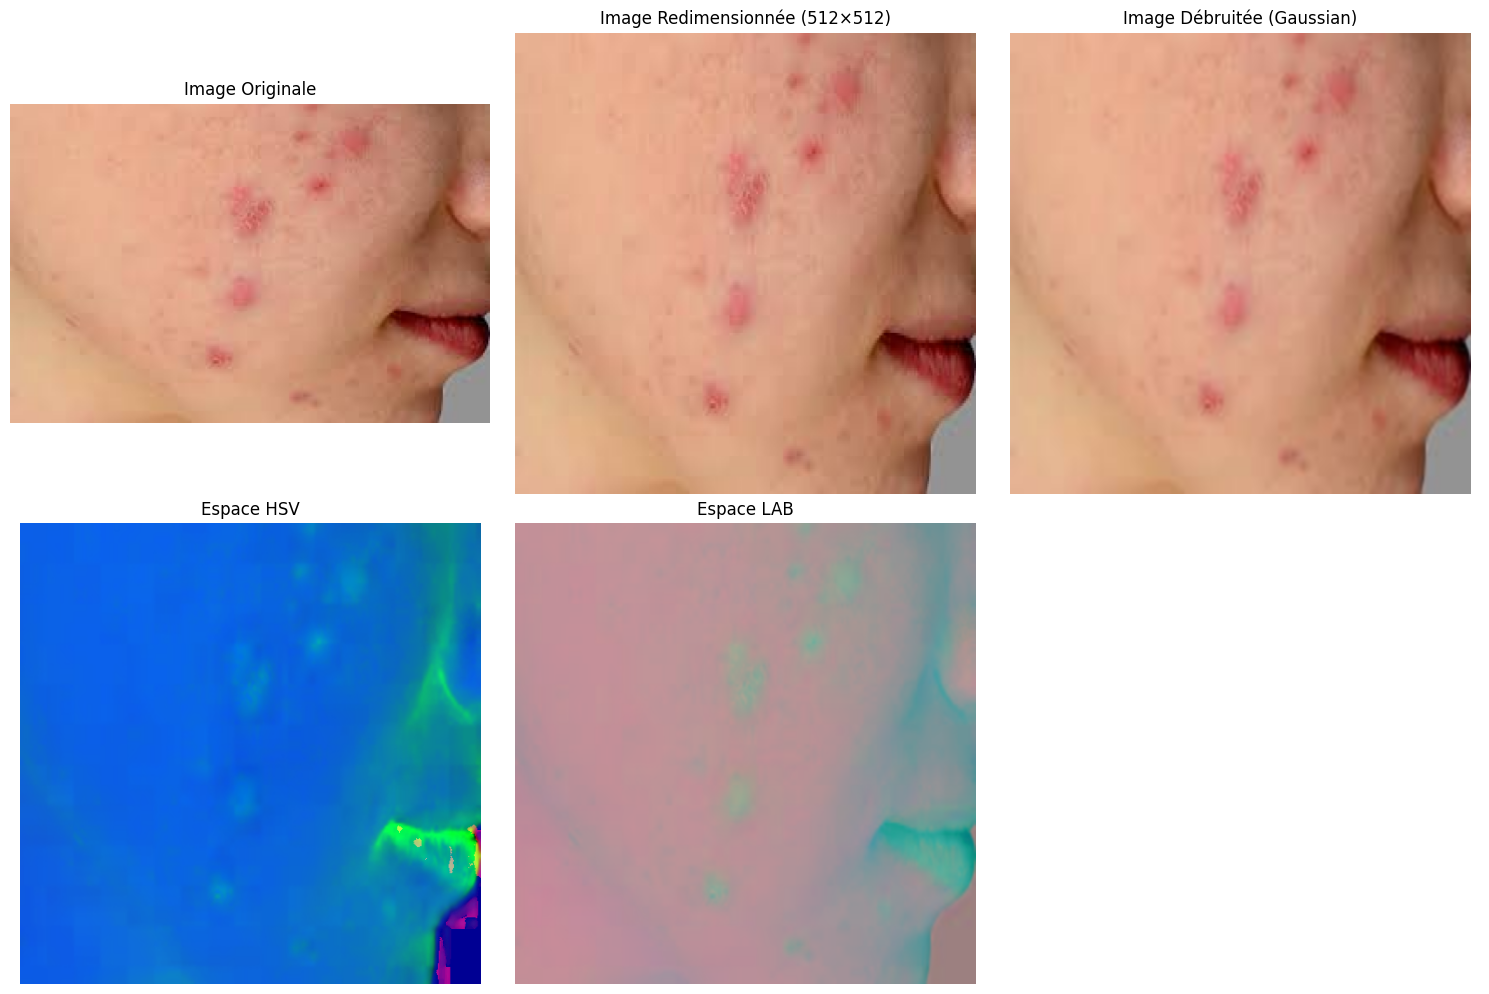

 Segmentation de la lésion...


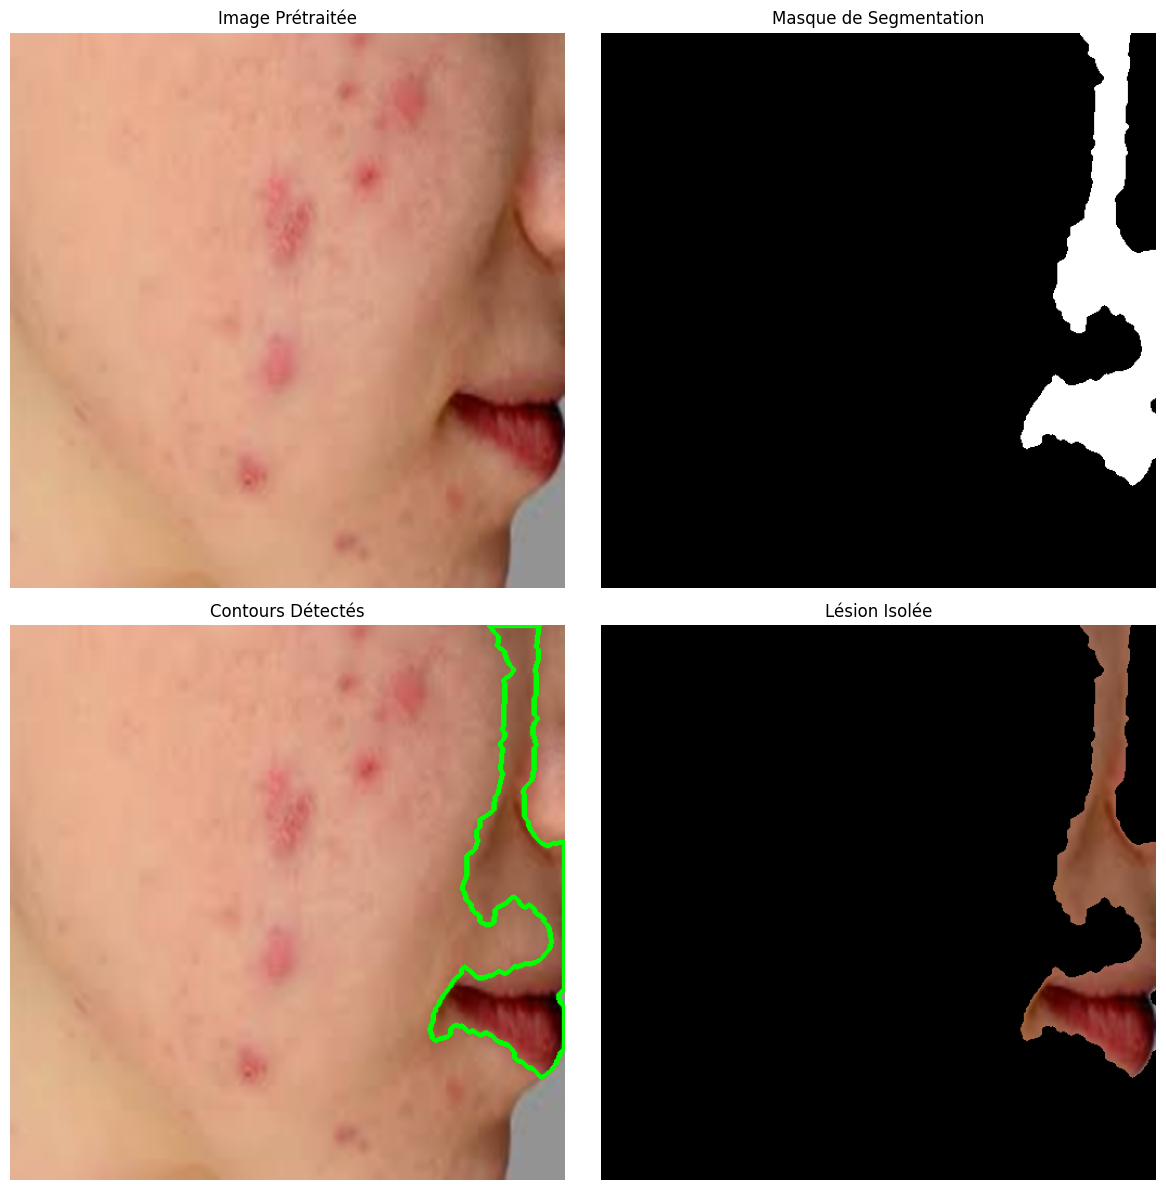

 Lésion détectée
 Extraction des caractéristiques de forme...
 Extraction des caractéristiques de couleur...


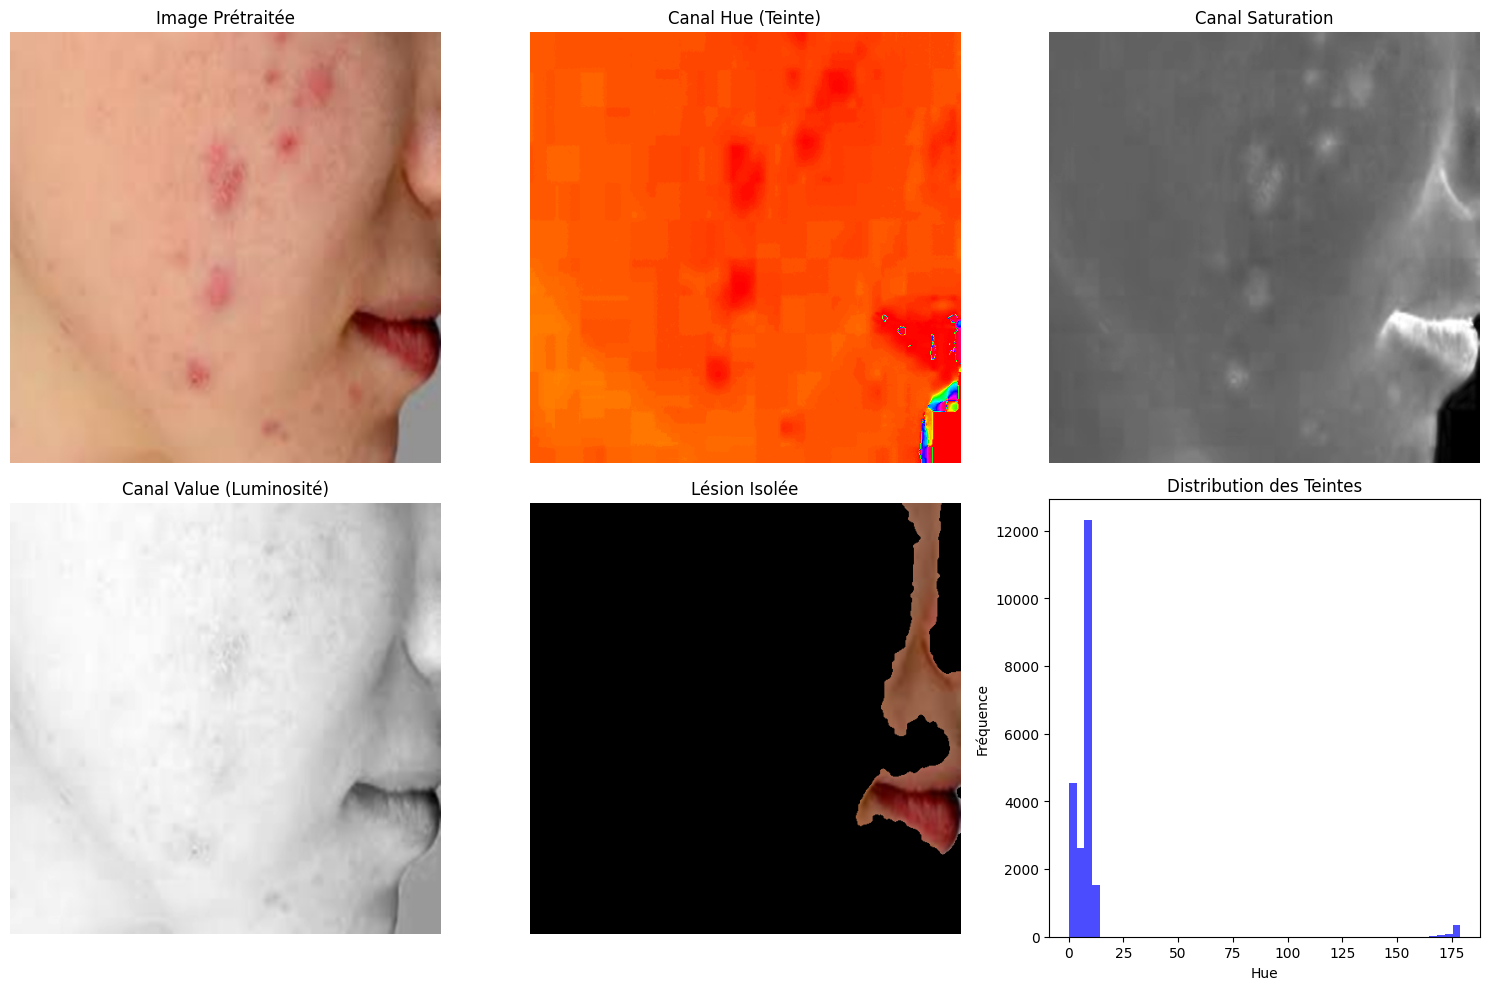

 Extraction des caractéristiques de texture...
 Calcul du scoring visuel...

 Analyse terminée avec succès!

 RÉSULTATS DE L'ANALYSE VISUELLE
{
  "area_pixels": 20954.5,
  "perimeter": 1287.9036697149277,
  "asymmetry_score": 0.7203322181335345,
  "border_irregularity_score": 0.5483090182658938,
  "color_variance": 12.306517794904641,
  "redness_level": "high",
  "texture_homogeneity_level": "high",
  "visual_risk_level": "medium"
}


In [18]:
image_path = "../data/images/image4.jpg"

# Analyser l'image
result = analyze_skin_image(image_path, visualize=True)

# Afficher les résultats
if result:
    print("\n" + "="*70)
    print(" RÉSULTATS DE L'ANALYSE VISUELLE")
    print("="*70)
    print(json.dumps(result['summary'], indent=2, ensure_ascii=False))
    print("="*70)

##  Export des Résultats

In [14]:
def save_analysis_results(result: Dict, output_path: str = "analysis_results.json"):
    """
    Sauvegarde les résultats d'analyse dans un fichier JSON.
    
    Args:
        result: Dictionnaire de résultats
        output_path: Chemin du fichier de sortie
    """
    if result:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        print(f" Résultats sauvegardés dans {output_path}")
    else:
        print(" Aucun résultat à sauvegarder")

# Sauvegarder les résultats dans un fichier JSON
if result:
    save_analysis_results(result, "skin_analysis_output.json")

##  Visualisation des Scores Globaux

In [ ]:
def visualize_scores(result: Dict):
    """
    Visualise les scores visuels sous forme de graphique radar.
    """
    if not result or not result.get('lesion_detected'):
        print("Aucune lésion à visualiser")
        return
    
    scores = result['visual_scores']
    
    categories = ['Asymétrie', 'Bord', 'Couleur', 'Texture']
    values = [
        scores['asymmetry_score'],
        scores['border_irregularity_score'],
        scores['color_score'],
        scores['texture_score']
    ]
    
    # Graphique radar
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw=dict(projection='polar'))
    
    # Radar chart
    ax1.plot(angles, values, 'o-', linewidth=2, color='blue')
    ax1.fill(angles, values, alpha=0.25, color='blue')
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories)
    ax1.set_ylim(0, 1)
    ax1.set_title('Scores Visuels (0-1)', pad=20)
    ax1.grid(True)
    
    # Bar chart
    ax2.remove()
    ax2 = fig.add_subplot(1, 2, 2)
    
    colors = ['red' if v > 0.6 else 'orange' if v > 0.3 else 'green' for v in values[:-1]]
    ax2.barh(categories, values[:-1], color=colors, alpha=0.7)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Score')
    ax2.set_title('Scores par Critère')
    ax2.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Seuil bas')
    ax2.axvline(x=0.6, color='red', linestyle='--', alpha=0.5, label='Seuil élevé')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Afficher le niveau de risque visuel
    risk_level = scores['visual_risk_level']
    risk_colors = {'low': 'low', 'medium': 'medium', 'high': 'high'}
    print(f"\n{risk_colors[risk_level]} Niveau de risque visuel: {risk_level.upper()}")
    print(f"Score global: {scores['global_visual_score']:.3f}")

# Visualiser les scores
if result:
    visualize_scores(result)

## Conclusion

Ce notebook implémente le pipeline complet d'analyse visuelle d'images dermatologiques avec OpenCV.

### Fonctionnalités implémentées

 **Prétraitement**: Redimensionnement, débruitage, conversion d'espaces couleur

 **Segmentation**: K-means clustering avec post-traitement morphologique

 **Extraction de caractéristiques**:
- Forme: aire, périmètre, circularité, asymétrie, irrégularité des bords
- Couleur: variance, rougeur, obscurité
- Texture: homogénéité, contraste, énergie (GLCM)

 **Scoring visuel**: Calcul de scores normalisés et niveau de risque visuel

 **Visualisations**: À chaque étape du pipeline

### Utilisation dans le système global

Les résultats de ce module peuvent être transmis au VLM sous forme de prompt structuré :

```python
# Exemple d'intégration avec VLM
features_text = f"""
Caractéristiques visuelles détectées:
- Asymétrie: {result['summary']['asymmetry_score']:.2f}
- Irrégularité des bords: {result['summary']['border_irregularity_score']:.2f}
- Niveau de rougeur: {result['summary']['redness_level']}
- Homogénéité de texture: {result['summary']['texture_homogeneity_level']}
- Risque visuel: {result['summary']['visual_risk_level']}
"""
```

